In [2]:
"""
    Reconstructiong MNIST images using a Deep Convolution GAN
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [158]:
# creating minibatches
def mini_batch(X, size):
    # generate random integers of shape size*1 and in range 0 to len(X)
    # treat x_bat as indices and return values from X at those indices
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, 28, 28, 1)
    
    return x_bat

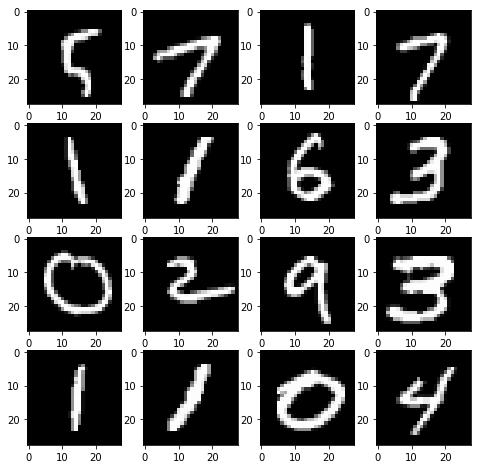

In [3]:
# importing dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

del(y_train, y_test)

fig = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    plt.imshow(x_train[j+100], cmap='gray')
    j+=1
plt.show()

In [157]:
# hyperparameters
sample_size = 32
epoch = 1

tf.reset_default_graph()

# input and labels placeholders
fake_x = tf.placeholder(tf.float32, [None, 4,4,1])  
real_x = tf.placeholder(tf.float32, [None, 28,28,1])
labels = tf.placeholder(tf.float32, [None, 1])


# generator network weights
gen_weight = {'w_c1': tf.get_variable('w_c1', [3,3,1,32], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c2': tf.get_variable('w_c2', [3,3,32,64], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c3': tf.get_variable('w_c3', [3,3,64,64], initializer=tf.contrib.layers.xavier_initializer()),
              'w_c4': tf.get_variable('w_c4', [3,3,64,1], initializer=tf.contrib.layers.xavier_initializer())
    
}

dis_weight = {'d_c1': tf.get_variable('d_c1', [3,3,1,32], initializer=tf.contrib.layers.xavier_initializer()), 
              'd_c2': tf.get_variable('d_c2', [3,3,32,64], initializer=tf.contrib.layers.xavier_initializer()),
              'd_c3': tf.get_variable('d_c3', [3,3,64,64], initializer=tf.contrib.layers.xavier_initializer()),
              'd_c4': tf.get_variable('d_c4', [3,3,64,1], initializer=tf.contrib.layers.xavier_initializer())
}

In [140]:
# generator network

def generator(fake, gen_wt):
    conv_1 = tf.nn.relu(tf.nn.conv2d(fake, gen_wt['w_c1'], strides=[1,1,1,1], padding='SAME'))

    up_scale_1 = tf.image.resize_images(conv_1, [14,14], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    conv_2 = tf.nn.relu(tf.nn.conv2d(up_scale_1, gen_wt['w_c2'], strides=[1,1,1,1], padding='SAME'))

    drop_2 = tf.nn.dropout(conv_2, 0.8)

    up_scale_2 = tf.image.resize_images(drop_2, [28,28], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    conv_3 = tf.nn.relu(tf.nn.conv2d(up_scale_2, gen_wt['w_c3'], strides=[1,1,1,1], padding='SAME'))

    generate = tf.nn.relu(tf.nn.conv2d(conv_3, gen_wt['w_c4'], strides=[1,1,1,1], padding='SAME'))

    #cost_func = tf.reduce_mean(tf.squared_difference(real, generate))

    #optimize = tf.train.AdamOptimizer(0.001).minimize(cost_func)
    
    return generate

In [111]:
# discriminator network
def discriminator(imgs, dis_wt):
    c1 = tf.nn.relu(tf.nn.conv2d(imgs, dis_wt['d_c1'], strides=[1,1,1,1], padding='SAME'))
    m1 = tf.nn.avg_pool(c1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    c2 = tf.nn.relu(tf.nn.conv2d(m1, dis_wt['d_c2'], strides=[1,1,1,1], padding='SAME'))
    m2 = tf.nn.avg_pool(c2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    d2 = tf.nn.dropout(m2, 0.8)
    
    c3 = tf.nn.relu(tf.nn.conv2d(d2, dis_wt['d_c3'], strides=[1,1,1,1], padding='SAME'))
    m3 = tf.nn.avg_pool(c3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    d3 = tf.nn.dropout(m3, 0.8)
    
    f4 = tf.layers.flatten(d3)
    d4 = tf.layers.dense(f4, 16, activation='sigmoid', trainable=True)
    d5 = tf.layers.dense(d4,  1, activation='sigmoid', trainable=True)
    
    return d5

In [159]:
# create noise sample
noise = np.random.normal(0, 0.1,[sample_size, fake_x.shape[1], fake_x.shape[2], fake_x.shape[3]])

real_imgs = x_train[0:sample_size].reshape(sample_size,28,28,1)


